In [40]:
import random
import numpy as np
import copy
import glob
import matplotlib.pyplot as plt
from scipy.misc import imresize

In [380]:
class CellularSpace(object):
    def __init__(self, params, x=24, y=24, density_map=None, vaccination_map=None):
        '''
        
        '''
        super().__init__()
        self.density_map = density_map          
        self.vaccination_map = vaccination_map   
        self.x = x #define space size
        self.y = y #define space size
        self.d = params['d_inf']
        self.__fill_space__()  #current state
    
    def __resize_map__(self, orignal_map):
        resized_map = copy.deepcopy(orignal_map) 
        resized_map = imresize(resized_map, (self.x, self.y))
        return resized_map
 
    def __fill_space__(self):
        #create 3D space for XxY map. Each cell in 1D array [S, I_1, ...I_d, R]
        #Sum(cell) = const 
        #The epidemic is not lethal and no birth, immigration or emigration is not considered
        self.resized_density_map = self.__resize_map__(self.density_map)
        self.space = np.zeros((self.x, self.y, self.d+2))
        self.space[:,:,0] = self.resized_density_map[:,:]
        
    def __space_to_plot__(self):
        infected_space = np.sum(self.space, axis=2)
        assert ((infected_space == self.resized_density_map).all),"Density invariant error"
        
        infected_space -= self.space[:,:,0] #exclude # of susceptible individuals
        infected_space -= self.space[:,:,-1] #exclude # of recovered individuals
        return infected_space
    
    def get_cell_state(self, cell):
        return self.space[cell[0],cell[1], :]

    def reset(self):
        self.__fill_space__()
        
    def update(self, plot_space = False): 
        # update cellular space for the next timestamp of the each cell [S, I_1, ...I_d, R]
        current_state = copy.deepcopy(self.space)
        for i in range(self.x):
            for j in range(self.y):
                cell_to_update = self.space[i,j,:]
                self.space[i,j,:] = self.__update_cell_state__(cell_to_update, i,j, current_state)
    
    def get_infected_neighbors(self, space, x, y, max_distance = 1):
        '''
        return pairs: (distance, portion of infected individuals)
        '''
        def get_cell_infection(space, x, y):
            if space[x,y,:].sum() == 0:
                return 0
            return space[x,y,1:-1].sum()/space[x,y,:].sum()

        infected_neighbors = []

        #indices for Von Neumann neighborhoods with radius = 1
        # V = {(0,0), (-1,0), (0,1), (1,0), (0,-1)}
                
        infected_neighbors.append((0, get_cell_infection(space, x, y))) #infected inside current cell 
        if x>0:
            infected_neighbors.append((0, get_cell_infection(space, x-1, y))) 
            
        if y>0:
            infected_neighbors.append((0, get_cell_infection(space, x, y-1))) 
            
        if x < space.shape[0]-1:
            infected_neighbors.append((0, get_cell_infection(space, x+1, y))) 
            
        if y < space.shape[1]-1:
            infected_neighbors.append((0, get_cell_infection(space, x, y+1)))     
        
        print(f'cell ({x}, {y}): {infected_neighbors}')
        return infected_neighbors
        
    def __update_cell_state__(self, cell, x, y, space):
        def flip(p):
            return 1 if random.random() < p else 0
            
        #[S, I_1, ...I_d, R]
        # Estimate # of individualds getting infection S-> I_1
        infected_neighbors = self.get_infected_neighbors(space, x, y)
         
        # Estimate # of individualds getting recovering I_d-> R
        
        
        return cell
    
    def get_infection(self, cell = None, n_infected = 1):
        if cell == None:
            cell = (np.random.randint(0, self.x, size=1), np.random.randint(0, self.y, size=1))
        
        if self.space[cell[0], cell[1], 0] < n_infected:
            print(f'In ({cell[0]}, {cell[1]}) lives only {self.space[cell[0], cell[1], 0]} \\
                    people. {n_infected} can not be infected')
            return
        
        self.space[cell[0], cell[1], 1] = n_infected    
        self.space[cell[0], cell[1], 0] -= n_infected #decrease # of susceptible individuals
        print(f'cell {cell} is infected')
    
    def plot(self, it = None, mode = 'dm'):
        '''
        mode: 'dm' - density map; 'vm' - vaccination map; 'sm' - space map
        '''
        im = {'dm': self.resized_density_map,
#             'vm': self.__resize_map__(self.vaccination_map),
              'sm': self.__space_to_plot__()}.get(mode, None)

        color = {'dm': plt.cm.YlGn, 'vm': plt.cm.OrRd, 'sm': plt.cm.OrRd}.get(mode, None)
        color.set_under(color='white') #black
        
        plt.figure(figsize=(10,10))
        if im.sum() >0:
            # vmin should be > max value that is not true for zero array
            plt.imshow(im, cmap=color, vmin=0.0000001, vmax = self.resized_density_map.max())
        else:
            plt.imshow(im, cmap=color)
            
        plt.title('iter {}'.format(it))
        ax = plt.gca();

        # Major ticks
        ax.set_xticks(np.arange(0, self.x, 1));
        ax.set_yticks(np.arange(0, self.y, 1));

        # Minor ticks
        ax.set_xticks(np.arange(-.5, self.x, 1), minor=True);
        ax.set_yticks(np.arange(-.5, self.y, 1), minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    

In [201]:
params = {'d_inf': 5}

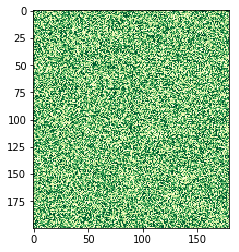

In [212]:
#test 1. Random
density_map = np.random.randint(50, 500, size=(200, 180))
plt.imshow(density_map, cmap='YlGn')
plt.show()

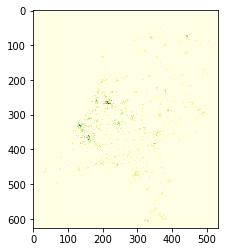

In [280]:
#test 2. The Netherlads density map
from parsepop import get_ca
density_map = np.array(get_ca('500x500data.csv'))
density_map = np.flip(density_map, axis = 0)
plt.imshow(density_map, cmap='YlGn')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


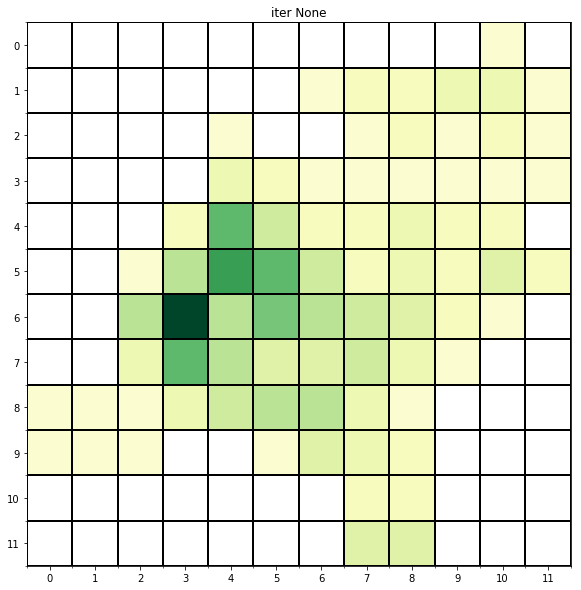

In [381]:
cellular_space = CellularSpace(params, x=12, y=12, density_map = density_map)
cellular_space.plot(mode = 'dm')

In [383]:
cellular_space.get_cell_state((4,4))

array([10.,  0.,  0.,  0.,  0.,  0.,  0.])

In [384]:
cellular_space.get_infection(cell = (4,4), n_infected = 1)

cell (4, 4) is infected


In [385]:
cellular_space.get_cell_state((4,4))

array([9., 1., 0., 0., 0., 0., 0.])

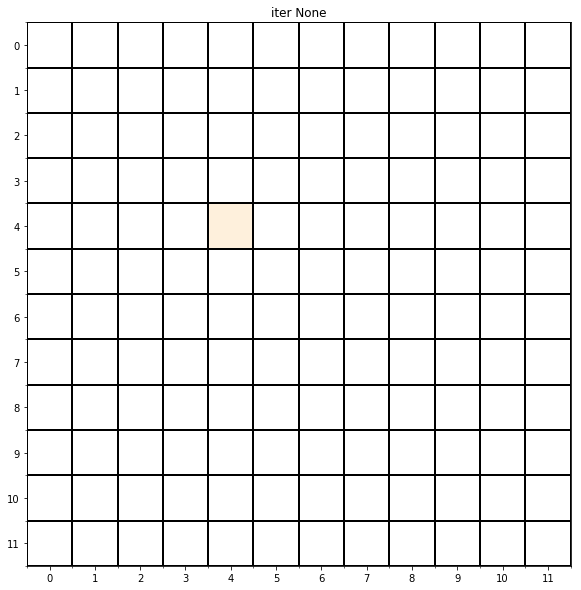

In [386]:
cellular_space.plot(mode = 'sm')

In [387]:
cellular_space.update()

cell (0, 0): [(0, 0), (0, 0), (0, 0)]
cell (0, 1): [(0, 0), (0, 0), (0, 0), (0, 0)]
cell (0, 2): [(0, 0), (0, 0), (0, 0), (0, 0)]
cell (0, 3): [(0, 0), (0, 0), (0, 0), (0, 0)]
cell (0, 4): [(0, 0), (0, 0), (0, 0), (0, 0)]
cell (0, 5): [(0, 0), (0, 0), (0, 0), (0, 0)]
cell (0, 6): [(0, 0), (0, 0), (0, 0.0), (0, 0)]
cell (0, 7): [(0, 0), (0, 0), (0, 0.0), (0, 0)]
cell (0, 8): [(0, 0), (0, 0), (0, 0.0), (0, 0)]
cell (0, 9): [(0, 0), (0, 0), (0, 0.0), (0, 0.0)]
cell (0, 10): [(0, 0.0), (0, 0), (0, 0.0), (0, 0)]
cell (0, 11): [(0, 0), (0, 0.0), (0, 0.0)]
cell (1, 0): [(0, 0), (0, 0), (0, 0), (0, 0)]
cell (1, 1): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
cell (1, 2): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
cell (1, 3): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
cell (1, 4): [(0, 0), (0, 0), (0, 0), (0, 0.0), (0, 0)]
cell (1, 5): [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0.0)]
cell (1, 6): [(0, 0.0), (0, 0), (0, 0), (0, 0), (0, 0.0)]
cell (1, 7): [(0, 0.0), (0, 0), (0, 0.0), (0, 0.0), (0, 0.0)]
cell